In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('./..'))

In [3]:
import control as ct
import numpy as np
import scipy as sp  
import matplotlib.pyplot as plt
import sysid_pem_toolbox.sysid_pem as sid


   z - 0.4
-------------
z^2 - z + 0.5

dt = 0.01


z - 0.7
-------
z - 0.9

dt = 0.01



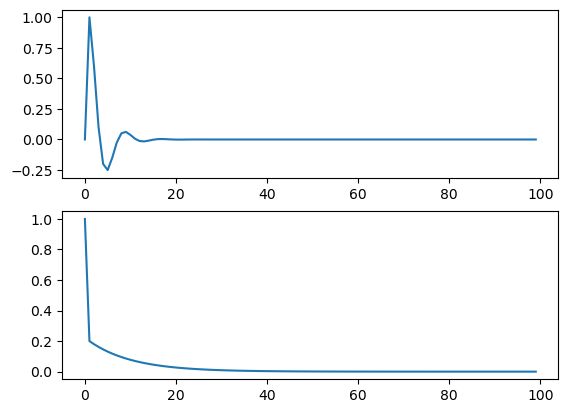

In [4]:
N = 1001
t = np.linspace(0,10,N)
t = t[0:-1]
N = 1000
Ts = t[1]-t[0]

A0 = np.array([1, -1, 0.5])
B0 = np.array([1, -0.4])
G0 = ct.tf(B0, A0, Ts)
print(G0)



C0 = np.array([1, -0.7])
D0 = np.array([1, -0.9])
H0 = ct.tf(C0, D0,Ts)
print(H0)


tt0, g0 = ct.impulse_response(G0,T=t[0:100])
G0_mag, G0_phase, omega2 = ct.bode_plot(G0,plot=False)

tth,h0 = ct.impulse_response(H0,T=t[0:100])

fig, ax = plt.subplots(2,1)
ax[0].plot(g0*Ts)
ax[1].plot(h0*Ts)




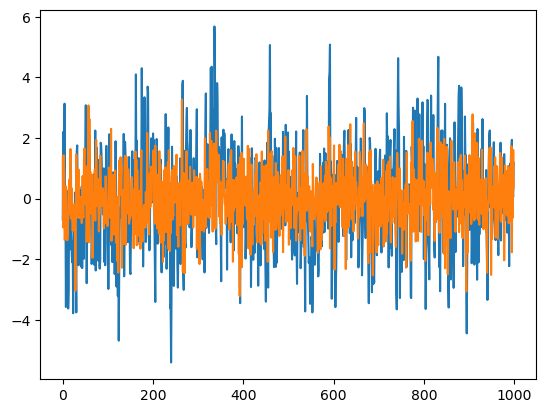

In [5]:
# input 1
r = np.random.randn(N)
e = np.random.randn(N)

tt, v = ct.forced_response(H0,T=t,U=e)
tt, y = ct.forced_response(G0,T=t,U=r)
y = y + v

fig,ax = plt.subplots(1)
ax.plot(y)
ax.plot(r)


In [7]:
m = 20
nb = m
na = m
nk = 1
n_arx = [na, nb, nk]

ng = nb+1
nh = na+1

theta = sid.V_arx_lin_reg(n_arx,y,r)

A = -theta[0:na]
B = theta[na:nb+na]

#rB = np.concatenate(([B[0]], np.zeros(na-1)))
#cB = B
    
#rA = np.concatenate(([1], np.zeros(na-1)))
#cA = np.concatenate(([1], -A[0:na-1]))

#CB = sp.linalg.toeplitz(cB,r=rB)
#CA = sp.linalg.toeplitz(cA,r=rA)
    
#M = np.block([[np.zeros((na,nb)), CA], [np.eye(nb), -CB]])

rB = np.zeros(nh)
cB = np.concatenate(([0],B,np.zeros(ng-nb-1)))

rA = np.concatenate(([1], np.zeros(nh-1)))
cA = np.concatenate(([1], -A, np.zeros(nh-na-1)))

CB = sp.linalg.toeplitz(cB,r=rB)
CA = sp.linalg.toeplitz(cA,r=rA)

M = np.block([[np.eye(ng), -CB],[np.zeros((nh,ng)), CA]])
V = np.concatenate((B,np.zeros(ng-nb),A,np.zeros(nh-na)))
    
theta_gh = np.linalg.inv( M.T @ M ) @ (M.T @ V)




#theta_gh = np.linalg.inv( M.T @ M ) @ (M.T @ np.concatenate((A, B)))

g = np.concatenate((np.zeros(nk), theta_gh[0:ng]))
h = np.concatenate(([1], theta_gh[ng:ng+nh]))



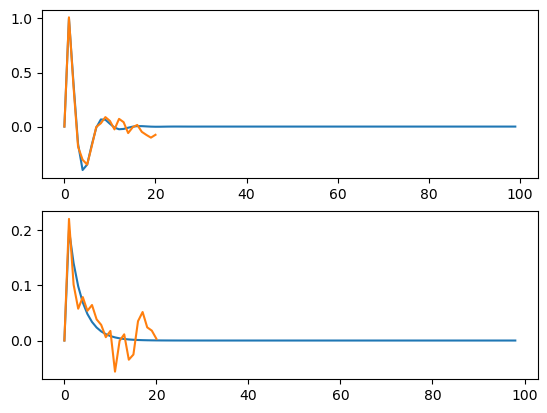

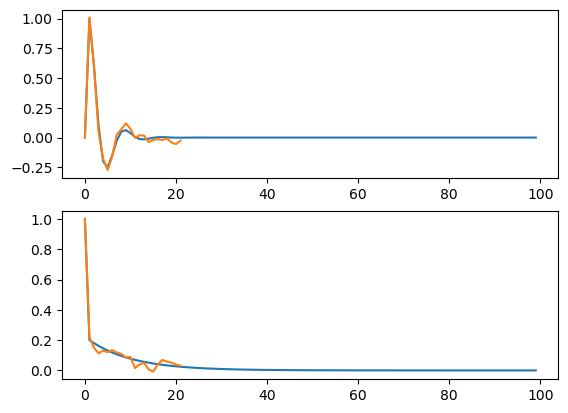

In [8]:
fig,ax = plt.subplots(2,1)
tt,hig = ct.impulse_response(G0/H0,T=t[0:100])
tt,hi = ct.impulse_response(1/H0,T=t[0:100])
ax[0].plot(hig*Ts)
ax[0].plot(np.concatenate((np.zeros(nk),B)))
ax[1].plot(np.concatenate((np.zeros(1),-hi[1:-1]*Ts)))
ax[1].plot(np.concatenate((np.zeros(1),A)))

fig,ax = plt.subplots(2,1)
ax[0].plot(g0*Ts)
ax[0].plot(g)
ax[1].plot(h0*Ts)
ax[1].plot(h)

In [9]:
na = 2
nb = 2
Cg = np.array(sp.linalg.toeplitz(np.concatenate(([0],g[nk:nk+ng-1])),r=np.zeros(na)))
Meye = np.concatenate((np.eye(nb), np.zeros((ng-nb,nb))),axis=0)
M = np.concatenate((Meye,-Cg),axis=1)
thetaBA = np.linalg.inv( M.T @ M ) @ (M.T @ g[nk:ng+nk] )

Gest = ct.tf(thetaBA[0:nb], np.concatenate(([1],thetaBA[nb:nb+na])),Ts)
print(thetaBA)
print(G0)
print(Gest)

[ 1.01059968 -0.30517351 -0.89127936  0.45591694]

   z - 0.4
-------------
z^2 - z + 0.5

dt = 0.01


   1.011 z - 0.3052
-----------------------
z^2 - 0.8913 z + 0.4559

dt = 0.01



In [10]:
nc = 1
nd = 1
Ch = np.array(sp.linalg.toeplitz(h[0:nh],r=np.concatenate(([1],np.zeros(nd-1)))))
Meye = np.concatenate((np.eye(nc), np.zeros((nh-nc,nc))),axis=0)
M = np.concatenate((Meye,-Ch),axis=1)
thetaCD = np.linalg.inv( M.T @ M ) @ (M.T @ h[1:nh+1] )

Hest = ct.tf(np.concatenate(([1],thetaCD[0:nc])), np.concatenate(([1],thetaCD[nc:nc+nd])),Ts)
print(thetaCD)
print(H0)
print(Hest)

[-0.60607587 -0.82585479]

z - 0.7
-------
z - 0.9

dt = 0.01


z - 0.6061
----------
z - 0.8259

dt = 0.01



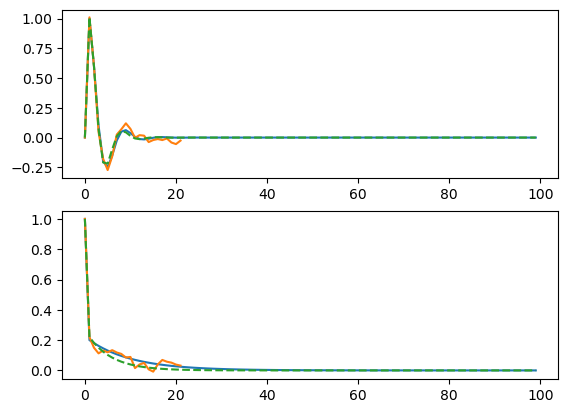

In [11]:
tt,g_est = ct.impulse_response(Gest,T=t[0:100])
tt,h_est = ct.impulse_response(Hest,T=t[0:100])

fig,ax = plt.subplots(2,1)
ax[0].plot(g0*Ts)
ax[0].plot(g)
ax[0].plot(g_est*Ts,'--')

ax[1].plot(h0*Ts)
ax[1].plot(h)
ax[1].plot(h_est*Ts,'--')

In [12]:
nf = na
n_bj = [nb,nc,nd,nf,nk]
theta_init_bj = np.concatenate((thetaBA[0:nb], thetaCD, theta[nb:nb+na]))
optimization_results_bj = sp.optimize.least_squares(sid.V_box_jenkins, theta_init_bj, jac=sid.jac_V_bj, args=(n_bj,y,r))

G_est_bj, H_est_bj = sid.theta_2_tf_box_jenkins(optimization_results_bj.x,n_bj,Ts)

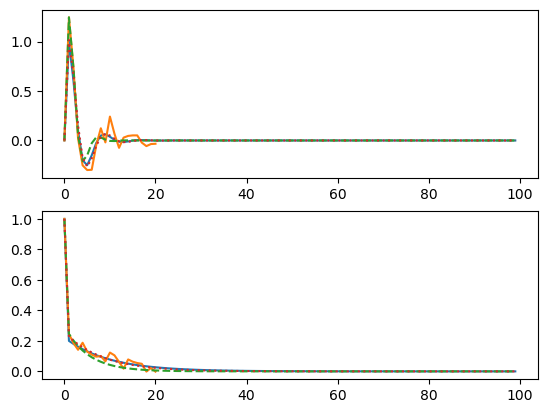

In [24]:
tt,g_est_bj = ct.impulse_response(G_est_bj,T=t[0:100])
tt,h_est_bj = ct.impulse_response(H_est_bj,T=t[0:100])

fig,ax = plt.subplots(2,1)
ax[0].plot(g0*Ts)
ax[0].plot(g)
ax[0].plot(g_est*Ts,'--')
ax[0].plot(g_est_bj*Ts,':')

ax[1].plot(h0*Ts)
ax[1].plot(h)
ax[1].plot(h_est*Ts,'--')
ax[1].plot(h_est_bj*Ts,':')

In [5]:
nf = 2
nb = 2
nc = 1
nd = 1
nk = 1
n_bj = [nb,nc,nd,nf,nk]
n_ho = [20,20]
theta_init_bj = sid.get_initial_estimate_box_jenkins(n_bj,n_ho,y,r)
optimization_results_bj = sp.optimize.least_squares(sid.V_box_jenkins, theta_init_bj, jac=sid.jac_V_bj, args=(n_bj,y,r))

G_est_bj, H_est_bj = sid.theta_2_tf_box_jenkins(optimization_results_bj.x,n_bj,Ts)

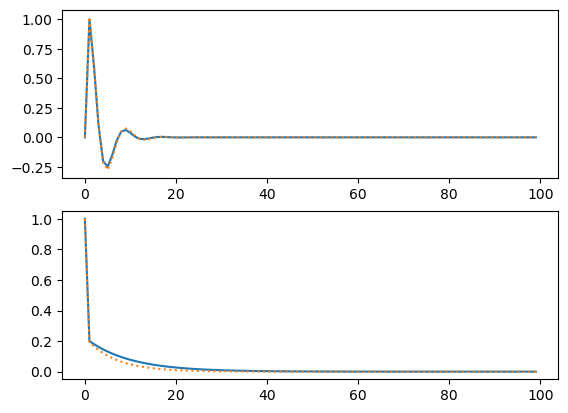

In [7]:
fig,ax = plt.subplots(2,1)
tt,g_est_bj = ct.impulse_response(G_est_bj,T=t[0:100])
tt,h_est_bj = ct.impulse_response(H_est_bj,T=t[0:100])

ax[0].plot(g0*Ts)
ax[0].plot(g_est_bj*Ts,':')

ax[1].plot(h0*Ts)
ax[1].plot(h_est_bj*Ts,':')